In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2939491e6f20c0679e1148bc093bea6c56288e1615bf01755ab578bb9a9b67cd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import re
from pyspark.sql.functions import length
from pyspark.sql import functions as F

In [4]:
data = spark.read.csv('/content/drive/MyDrive/Scalable_Final_Project/yelp-dataset/part-00000-088a67a0-1eba-42ac-af32-e6ff21d882e4-c000.csv', inferSchema=True, header=True)

In [6]:
data.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)



In [7]:
data.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  NULL| NULL|NULL|
|Staff was very he...|                   0|                   0|    0|      NULL|                NULL|  NULL| NULL|NULL|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  NULL| NULL|NULL|
|We had their beef...|                NULL|                NULL| NULL|      NULL|                NULL|  NULL| NULL|NULL|
|A bit outside of ...|                   0|                   0|    0|      NULL|                NULL|  NULL| NULL|NULL|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5

In [8]:
data.count()

5848384

In [9]:
data = data.dropna(subset=["user_id", "text", "stars"])

In [ ]:
data.count()

3753374

In [10]:
data.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  NULL| NULL|NULL|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  NULL| NULL|NULL|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|  NULL| NULL|NULL|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|  NULL| NULL|NULL|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|  NULL| NULL|NULL|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [11]:
data = data.withColumn("stars", data["stars"].cast(IntegerType()))
valid_stars = [1, 2, 3, 4, 5]
data_filtered = data.filter(col("stars").isin(valid_stars))
data_filtered.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|  NULL| NULL|NULL|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|  NULL| NULL|NULL|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|  NULL| NULL|NULL|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|  NULL| NULL|NULL|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|  NULL| NULL|NULL|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [12]:
data_clean = data_filtered.drop('useful', 'funny','cool')

In [13]:
#Check user_id format
data_with_id_length = data_clean.withColumn("user_id_length", length("user_id"))
data_with_id_length.select("user_id", "user_id_length").show(50, truncate=False)

+--------------------------+--------------+
|user_id                   |user_id_length|
+--------------------------+--------------+
|bv2nCi5Qv5vroFiqKGopiw    |22            |
|bv2nCi5Qv5vroFiqKGopiw    |22            |
|bv2nCi5Qv5vroFiqKGopiw    |22            |
|bv2nCi5Qv5vroFiqKGopiw    |22            |
|bv2nCi5Qv5vroFiqKGopiw    |22            |
|_4iMDXbXZ1p1ONG297YEAQ    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22            |
|u0LXt3Uea_GidxRW1xcsfg    |22  

In [14]:
user_id_pattern = r'^[a-zA-Z0-9_-]{22}$'

valid_data = data_clean.filter(col('user_id').rlike(user_id_pattern))

valid_data.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+
|           review_id|             user_id|         business_id|stars|      date|                text|
+--------------------+--------------------+--------------------+-----+----------+--------------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|    5|2014-09-24|Cycle Pub Las Veg...|
|ymAUG8DZfQcFTBSOi...|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|    4|201

In [15]:
valid_data.count()

2484513

In [26]:
valid_data.show(500)

+--------------------+--------------------+--------------------+-----+----------+--------------------+
|           review_id|             user_id|         business_id|stars|      date|                text|
+--------------------+--------------------+--------------------+-----+----------+--------------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|    5|2014-09-24|Cycle Pub Las Veg...|
|ymAUG8DZfQcFTBSOi...|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|    4|201

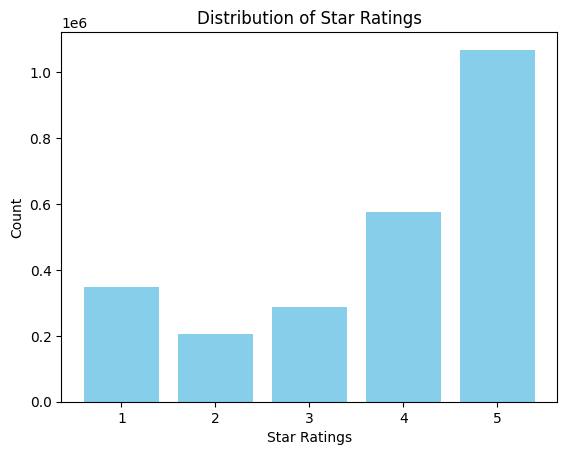

1 star: 346793
2 star: 207072
3 star: 287633
4 star: 574508
5 star: 1068507


In [21]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a Spark session (assuming it's not already created)
spark = SparkSession.builder.master("local[*]").appName("EDA with RDDs").getOrCreate()

# Assuming 'valid_data' is already loaded and available
rdd = valid_data.rdd

# Convert star ratings to integer and map each rating to (rating, 1) for counting
rdd = rdd.map(lambda row: (int(row.stars), 1))

# Reduce by key to count occurrences of each star rating
star_counts_rdd = rdd.reduceByKey(lambda a, b: a + b)

# Sort by the star rating
sorted_star_counts = star_counts_rdd.sortByKey().collect()

# Prepare data for plotting
stars = [row[0] for row in sorted_star_counts]
counts = [row[1] for row in sorted_star_counts]

# Plotting
plt.bar(stars, counts, color='skyblue')
plt.xlabel('Star Ratings')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')
plt.xticks(stars)
plt.show()

# Printing results
for star, count in sorted_star_counts:
    print(f"{star} star: {count}")


In [17]:
avg_rating_per_user = valid_data.groupBy('user_id').agg(F.avg('stars').alias('avg_rating'))
avg_rating_per_user.show()

+--------------------+------------------+
|             user_id|        avg_rating|
+--------------------+------------------+
|oKWVVqPWVzq5s6nS4...| 4.190476190476191|
|OcB8_br3QOUuX_CCg...|               4.0|
|5a7nRCjFm_QUjF8xy...|               1.0|
|DsPTtxXzLccDutfoJ...|               5.0|
|Y1N3yo62V5eIj_Zcn...|               5.0|
|qxpk8rO10eJ4_NGta...|               1.0|
|G5doo_5gjzejaECHv...|               1.0|
|TcRbqnOv6Mqfvhsdj...|               1.0|
|Q87V0vOAtbpxdkrF6...|               1.0|
|3F9rvmlmr6FHUronu...|               3.0|
|32vx6QPtlUvMFurvb...|               5.0|
|MFoN8dduPz4mwDMu1...|               1.0|
|bSA6m2r1k67uaEPCc...|               5.0|
|LEr8vS6PRymCg-SJH...|               3.0|
|_fuXIiQGOo0RrdzjQ...|               4.0|
|Xf2tlT1czROOdOgTG...|               2.0|
|xwL6r5RL8K81s6T1o...|               5.0|
|PqUQyGApS2pho7aox...|               5.0|
|2Hw061_FYIUKYIILd...|3.1666666666666665|
|KuGQIxKfGiHLNRuWL...| 3.723684210526316|
+--------------------+------------

In [18]:
avg_rating_per_user.count()

633771

In [19]:
def categorize_user(avg_rating):
    if avg_rating >= 4: return 'generous'
    elif avg_rating <= 2: return 'picky'
    else: return 'normal'
#UDF
categorize_user_udf = F.udf(categorize_user, StringType())

user_categories = avg_rating_per_user.withColumn('user_category', categorize_user_udf('avg_rating'))
user_categories.show()

+--------------------+------------------+-------------+
|             user_id|        avg_rating|user_category|
+--------------------+------------------+-------------+
|oKWVVqPWVzq5s6nS4...| 4.190476190476191|     generous|
|OcB8_br3QOUuX_CCg...|               4.0|     generous|
|5a7nRCjFm_QUjF8xy...|               1.0|        picky|
|DsPTtxXzLccDutfoJ...|               5.0|     generous|
|Y1N3yo62V5eIj_Zcn...|               5.0|     generous|
|qxpk8rO10eJ4_NGta...|               1.0|        picky|
|G5doo_5gjzejaECHv...|               1.0|        picky|
|TcRbqnOv6Mqfvhsdj...|               1.0|        picky|
|Q87V0vOAtbpxdkrF6...|               1.0|        picky|
|3F9rvmlmr6FHUronu...|               3.0|       normal|
|32vx6QPtlUvMFurvb...|               5.0|     generous|
|MFoN8dduPz4mwDMu1...|               1.0|        picky|
|bSA6m2r1k67uaEPCc...|               5.0|     generous|
|LEr8vS6PRymCg-SJH...|               3.0|       normal|
|_fuXIiQGOo0RrdzjQ...|               4.0|     ge

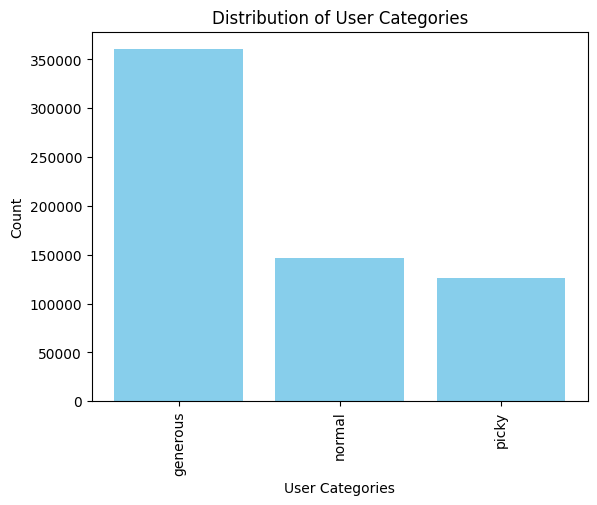

generous user: 360455
normal user: 146832
picky user: 126484


In [22]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a Spark session if it's not already created
spark = SparkSession.builder.master("local[*]").appName("EDA with RDDs - Categories").getOrCreate()

# Assuming 'user_categories' is a DataFrame already loaded
rdd = user_categories.rdd

# Map to (category, 1) for counting
category_counts_rdd = rdd.map(lambda row: (row.user_category, 1))

# Reduce by key to sum up the counts
reduced_category_counts = category_counts_rdd.reduceByKey(lambda a, b: a + b)

# Sort by count in descending order
sorted_category_counts = reduced_category_counts.sortBy(lambda pair: pair[1], ascending=False).collect()

# Prepare data for plotting
categories = [row[0] for row in sorted_category_counts]
counts = [row[1] for row in sorted_category_counts]

# Plotting
plt.bar(categories, counts, color='skyblue')
plt.xlabel('User Categories')
plt.ylabel('Count')
plt.title('Distribution of User Categories')
plt.xticks(categories, rotation=90)  # rotation for better label readability
plt.show()

# Printing results
for category, count in sorted_category_counts:
    print(f"{category} user: {count}")


Unique User Count: 633771


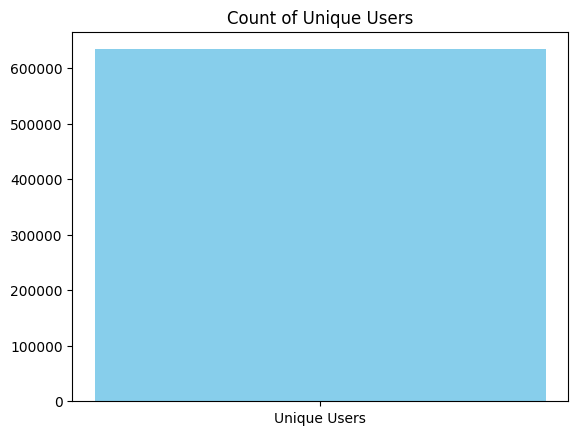

In [24]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Assuming the session is already created and 'user_data' is the DataFrame with user IDs
rdd = user_categories.rdd

# Map to (user_id, 1), then use distinct to remove duplicates
unique_user_ids_rdd = rdd.map(lambda row: (row.user_id, 1)).distinct()

# Count unique users
unique_user_count = unique_user_ids_rdd.count()

# For visualization, we'll just display the count as text since it's a single number
print(f"Unique User Count: {unique_user_count}")

# You could also create a bar graph with a single bar
plt.bar(['Unique Users'], [unique_user_count], color='skyblue')
plt.title('Count of Unique Users')
plt.show()
